## 프로젝트 목표

- 한국어 데이터로 챗봇 만들기

- 루브릭

|평가문항|상세기준|
|:---|:---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|

## 목차
---
### Step 1. 데이터 수집하기
### Step 2. 데이터 전처리하기
### Step 3. SubwordTextEncoder 사용하기
### Step 4. 모델 구성하기
### Step 5. 모델 평가하기

## 프로젝트 진행
---

### Step 1. 데이터 수집하기

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

- `Q, A 데이터쌍 불러오기`

In [147]:
df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
df.head(5)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- `데이터 구성 확인`

데이터별 개수
Q        11823
A        11823
label    11823
dtype: int64

결측치 확인
Q        0
A        0
label    0
dtype: int64

라벨의 종류 : [0 1 2]


<AxesSubplot:xlabel='label', ylabel='count'>

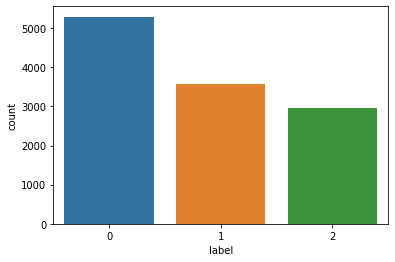

In [25]:
print("데이터별 개수")
print(df.count())
print()
print("결측치 확인")
print(df.isnull().sum())
print()
print(f"라벨의 종류 : {df['label'].unique()}")
sns.countplot(x=df['label'], data=df)

- `결측치가 없고` `라벨이 총 3가지`가 있으며, `데이터 분포가 불균형`한 것을 알 수 있었다.
- 상대적으로 데이터의 수가 적고, 자연어 분야의 데이터 증강기법은 아직 모르기에 추 후 챗봇의 성능 개선 시 참고하고자 관련 논문을 링크해두었다.

- 참고링크 : https://www.sciencedirect.com/science/article/abs/pii/S0969698922000303
    - 논문 제목 : (Im)Balanced customer-oriented behaviors and AI chatbots' Efficiency–Flexibility performance: The moderating role of customers’ rational choices
    - `불균형에 대한 부정적인 견해` : (Abstract 5번째 줄) Chatbots' level of efficiency–flexibility ambidexterity is higher when their functional and relational customer-oriented behaviors are balanced rather than imbalanced (i.e., a negative imbalance effect) and when they are balanced at a higher rather than a lower level (i.e., a positive balance effect).
    - `결론적으로 균형된 데이터를 학습해야 유용하고 유연성있는 모델이 완성`된다.
---
    - 단 시간관계상 이 부분은 성능개선에서 생각해보고자 한다.

- `라벨별 데이터 확인`
    - 일상다반사 0
    - 이별(부정) 1
    - 사랑(긍정) 2

In [30]:
df[df['label'] == 0].head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [31]:
df[df['label'] == 1].head()

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [32]:
df[df['label'] == 2].head()

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


AttributeError: 'Series' object has no attribute 'find'

In [35]:
from wordcloud import WordCloud
wordcloud = WordCloud(font_path=chosen_font, width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'chosen_font' is not defined

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud

# 사용 가능한 폰트 리스트 출력
available_fonts = [font for font in fm.fontManager.ttflist if 'Nanum' in font.name or 'nanum' in font.name]

if available_fonts:
chosen_font = available_fonts[0].fname # 첫 번째 폰트의 파일명을 선택
print("선택된 폰트:", chosen_font)

# 워드 클라우드 생성 시 선택된 폰트를 지정
wordcloud = WordCloud(font_path=chosen_font, width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
else:
print("Nanum 폰트가 사용 가능한 폰트 리스트에 없습니다.")

IndentationError: expected an indented block (256775075.py, line 9)

### Step 2. 데이터 전처리하기

- `ㅋ,ㅎ,ㅜ,ㅠ 데이터 처리 고민`

In [97]:
const = df['Q'].str.contains('[ㄱ-ㅎㅏ-ㅣ]') |\
df['A'].str.contains('[ㄱ-ㅎㅏ-ㅣ]')

In [98]:
df[const]

,Q,A,label
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
211,공무원 시험 힘들어ㅠㅠ,철밥통 되기가 어디 쉽겠어요.,0
1153,단둘이는 처음 만나는 날ㅋㅋ,서로를 아는 좋은 기회가 되겠네요.,0
2104,보일러 틀고 나갔어ㅠㅠ,이번달 난방비가 많이 나오겠네요.,0
2229,비트코인 ㅜㅜ,안타깝지만 잊어버리세요.,0
...,...,...,...
8778,황당하지만 재미난 일이 생겼네ㅎㅎ,무슨 일인지 말씀해주세요.,1
8787,후.ㅎㅎ,지쳤나봐요.,1
8815,휴우.,휴우ㅠㅠ,1
8819,흐잌~~ 불금이닷~~ㅠㅠ,퐈이야,1


- 관련한 데이터 77개 확인
- 데이터량이 작지만, ㅜㅠㅋㅎ은 한국어 표현에서 중요한 감정표현 정보이기에 `한 단어씩은 남기기`로 결정

- `영어 데이터 처리 고민`

In [100]:
const2 = df['Q'].str.contains('[a-zA-Z]') |\
df['A'].str.contains('[a-zA-Z]')

In [102]:
df[const2]

,Q,A,label
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요.,0
754,남친 SNS에 내 사진 없어,신경쓰지 마세요.,0
762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요.,0
1401,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0


In [103]:
df[const2].count()

Q        42
A        42
label    42
dtype: int64

- 관련한 데이터 42개 확인
- sns, SNS, as, AS 등 통일 작업 필요`(Upper 사용 결정)`
- 중요한 정보기에 남기기로 결정

- `숫자 데이터 처리 고민`

In [106]:
const3 = df['Q'].str.contains('[0-9]') |\
df['A'].str.contains('[0-9]')

In [107]:
df[const3]

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
67,강렬한 첫인상 남겨야 하는데,처음 3초가 중요해요. 당신의 매력을 어필해보세요.,0
...,...,...,...
10948,자기를 3인칭으로 말하는 여자친구의 말투가 고민임.,귀엽게 봐주세요.,2
11184,좋아하는 애가 1년만 기다려 달라는데 어쩌지.,기다릴 수 있다면 본인 의지대로 하셔요.,2
11257,좋아하는데 걸린 시간이 보통 어떻게 돼요?,1초가 걸릴 수도 있고 평생이 걸릴 수도 있어요.,2
11390,짝남이 내가 좋아하는걸 1도 몰라.,1은 알게 해야죠.,2


- 415개 데이터 확인
- 1지망, 1년, 3인칭 중요한 데이터가 두루 있는 것으로 판단되어 `살리는 것으로 결정`

- `전처리 함수 정의`

In [146]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation), (ㅋ,ㅎ,ㅜ,ㅠ) 사이의 거리를 만듭니다.
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 영어 소문자 -> 대문자 변환 결정
    sentence = re.sub(r'[a-z]', lambda x: x.group(0).upper(), sentence)
    # 한글 초성, 중성 하나씩으로 변경, 띄어쓰기
    sentence = re.sub(r"([ㄱ-ㅎㅏ-ㅣ])\1+", r"\1", sentence)
    sentence = re.sub(r"([ㄱ-ㅎㅏ-ㅣ])", r" \1 ", sentence)
    
    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다
    # 가-힣ㄱ-ㅎㅏ-ㅣ0-9 추가하여 결정
    sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [148]:
df['Q'] = df['Q'].apply(lambda x:preprocess_sentence(x))
df['A'] = df['A'].apply(lambda x:preprocess_sentence(x))

In [149]:
df[const]

,Q,A,label
7,SNS 맞팔 왜 안하지 ㅠ,잘 모르고 있을 수도 있어요 .,0
211,공무원 시험 힘들어 ㅠ,철밥통 되기가 어디 쉽겠어요 .,0
1153,단둘이는 처음 만나는 날 ㅋ,서로를 아는 좋은 기회가 되겠네요 .,0
2104,보일러 틀고 나갔어 ㅠ,이번달 난방비가 많이 나오겠네요 .,0
2229,비트코인 ㅜ,안타깝지만 잊어버리세요 .,0
...,...,...,...
8778,황당하지만 재미난 일이 생겼네 ㅎ,무슨 일인지 말씀해주세요 .,1
8787,후 . ㅎ,지쳤나봐요 .,1
8815,휴우 .,휴우 ㅠ,1
8819,흐잌 불금이닷 ㅠ,퐈이야,1


In [150]:
df[const2]

,Q,A,label
4,PPL 심하네,눈살이 찌푸려지죠 .,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요 .,0
7,SNS 맞팔 왜 안하지 ㅠ,잘 모르고 있을 수도 있어요 .,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,0
10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요 .,0
754,남친 SNS에 내 사진 없어,신경쓰지 마세요 .,0
762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요 .,0
1401,떨어뜨려서 핸드폰 액정 나갔어,AS 맡기세요 .,0


In [151]:
df[const3]

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
67,강렬한 첫인상 남겨야 하는데,처음 3초가 중요해요 . 당신의 매력을 어필해보세요 .,0
...,...,...,...
10948,자기를 3인칭으로 말하는 여자친구의 말투가 고민임 .,귀엽게 봐주세요 .,2
11184,좋아하는 애가 1년만 기다려 달라는데 어쩌지 .,기다릴 수 있다면 본인 의지대로 하셔요 .,2
11257,좋아하는데 걸린 시간이 보통 어떻게 돼요 ?,1초가 걸릴 수도 있고 평생이 걸릴 수도 있어요 .,2
11390,짝남이 내가 좋아하는걸 1도 몰라 .,1은 알게 해야죠 .,2


- 각자 요구사항별로 전처리된 것을 확인할 수 있다.

- `샘플 확인`

In [153]:
print('전체 샘플 수 :', len(df['Q']))
print('전체 샘플 수 :', len(df['A']))

print('전처리 후의 22번째 질문 샘플: {}'.format(df['Q'][21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(df['A'][21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### Step 3. SubwordTextEncoder 사용하기

- `단어장 만들기`

In [154]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df['Q'] + df['A'], target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

- `시작, 종료 토큰 번호 확인, 사이즈 조정`

In [155]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


- `정수 인코딩(Integer encoding) & 패딩(Padding) 변환결과 확인`

In [222]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(df['Q'][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(df['A'][21])))

정수 인코딩 후의 21번째 질문 샘플: [5828, 606, 2500, 4174]
정수 인코딩 후의 21번째 답변 샘플: [2684, 7667, 8, 6377, 95, 1]


- `문장의 최대 길이 지정(패딩(Padding) 값`

- 단어장 확인
    - 언더바의 의미
    - 예를 들어, "게임"이라는 단어를 부분 단어로 나누면 "게_"와 "임"으로 분할될 수 있습니다. 여기서 "게_"는 "게임"의 일부를 나타내는 부분 단어입니다. 이러한 부분 단어(subword)를 사용하는 이유는 언어의 다양성에 대응하기 위함입니다. 언어에 따라서 단어의 형태가 다양하게 나타날 수 있기 때문에, 부분 단어(subword) 단위로 토큰화하면 단어의 다양한 형태를 다룰 수 있습니다.(by chat-gpt)

In [193]:
tokenizer.subwords

[' .',
 ' ?',
 '거예요',
 '게_',
 '수_',
 '너무_',
 '는_',
 '더_',
 '거_',
 '좋아하는_',
 '이_',
 ' . ',
 '을_',
 '도_',
 '잘_',
 '고_',
 '것_',
 '요',
 '많이_',
 '안_',
 '같아요',
 '좋은_',
 '한_',
 '좀_',
 '있어요',
 '가_',
 '은_',
 '나_',
 '있을_',
 '에_',
 '지_',
 '해보세요',
 '할_',
 '사람_',
 '면_',
 '건_',
 ' !',
 '사람이_',
 '마세요',
 '를_',
 '다_',
 '하고_',
 '하는_',
 '보세요',
 '해',
 '죠',
 '의_',
 '서_',
 '내가_',
 '싶어',
 '지',
 '내_',
 '네',
 '마음이_',
 '이제_',
 '만_',
 '썸_',
 '어떻게_',
 '어',
 '같아',
 '있는_',
 '왜_',
 '다른_',
 '세요',
 '나',
 '수도_',
 '시간이_',
 '다시_',
 '다',
 '그_',
 '것도_',
 '또_',
 '좋을_',
 '오늘_',
 '정말_',
 '싶다',
 '같이_',
 '가',
 '이',
 '네요',
 '될_',
 '해요',
 '자꾸_',
 '걸_',
 '없어요',
 '하세요',
 '로_',
 '있어',
 '일_',
 '길_',
 '바랄게요',
 '까',
 '돼요',
 '에서_',
 '봐요',
 '하면_',
 '할까',
 '으로_',
 '때_',
 '될까',
 '주세요',
 '헤어진지_',
 '먼저_',
 '기_',
 '진짜_',
 '없어',
 '나를_',
 '고',
 '이별_',
 '여자친구가_',
 '야',
 '좋아요',
 '있을까',
 '제가_',
 '마음을_',
 '계속_',
 '혼자_',
 '없는_',
 '못_',
 '남자친구가_',
 '해도_',
 '드세요',
 '기',
 '줄_',
 '않아요',
 '먹고_',
 '는데_',
 '하지_',
 '좋죠',
 '저도_',
 '일이_',
 '아',
 '바랍니다',
 '데_'

- 문장 길이 결정용 vocab제작 : 언더바를 제거하고 단어들을 통해 개수를 구해본다.

In [213]:
vocab = tokenizer.subwords
vocab = [x.replace("_","") for x in vocab]
print(len(vocab))
vocab

8104


[' .',
 ' ?',
 '거예요',
 '게',
 '수',
 '너무',
 '는',
 '더',
 '거',
 '좋아하는',
 '이',
 ' . ',
 '을',
 '도',
 '잘',
 '고',
 '것',
 '요',
 '많이',
 '안',
 '같아요',
 '좋은',
 '한',
 '좀',
 '있어요',
 '가',
 '은',
 '나',
 '있을',
 '에',
 '지',
 '해보세요',
 '할',
 '사람',
 '면',
 '건',
 ' !',
 '사람이',
 '마세요',
 '를',
 '다',
 '하고',
 '하는',
 '보세요',
 '해',
 '죠',
 '의',
 '서',
 '내가',
 '싶어',
 '지',
 '내',
 '네',
 '마음이',
 '이제',
 '만',
 '썸',
 '어떻게',
 '어',
 '같아',
 '있는',
 '왜',
 '다른',
 '세요',
 '나',
 '수도',
 '시간이',
 '다시',
 '다',
 '그',
 '것도',
 '또',
 '좋을',
 '오늘',
 '정말',
 '싶다',
 '같이',
 '가',
 '이',
 '네요',
 '될',
 '해요',
 '자꾸',
 '걸',
 '없어요',
 '하세요',
 '로',
 '있어',
 '일',
 '길',
 '바랄게요',
 '까',
 '돼요',
 '에서',
 '봐요',
 '하면',
 '할까',
 '으로',
 '때',
 '될까',
 '주세요',
 '헤어진지',
 '먼저',
 '기',
 '진짜',
 '없어',
 '나를',
 '고',
 '이별',
 '여자친구가',
 '야',
 '좋아요',
 '있을까',
 '제가',
 '마음을',
 '계속',
 '혼자',
 '없는',
 '못',
 '남자친구가',
 '해도',
 '드세요',
 '기',
 '줄',
 '않아요',
 '먹고',
 '는데',
 '하지',
 '좋죠',
 '저도',
 '일이',
 '아',
 '바랍니다',
 '데',
 '보고',
 '이별',
 '힘든',
 '만큼',
 '생각해요',
 '말해보세요',
 '마음',
 '나봐요',
 '그런',
 '주',
 '좋겠어요',
 

- 문장 개수 세기용 메서드 정의

In [214]:
def len_word(word) :
    answer = 0
    for i in word.split(' '):
        if i in vocab:
            answer += 1
            
    return answer

In [215]:
df_len = df.copy()
df_len['Q'] = df_len['Q'].apply(lambda x:len_word(x))
df_len['A'] = df_len['A'].apply(lambda x:len_word(x))

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


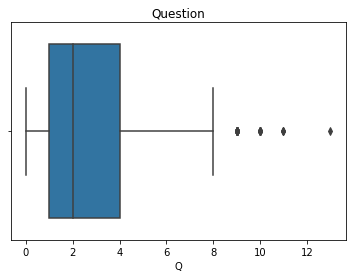

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


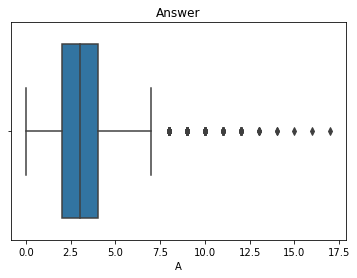

In [216]:
sns.boxplot(df_len['Q'])
plt.title('Question')
plt.show()
plt.title('Answer')
sns.boxplot(df_len['A'])
plt.show()

- 각각 8 쯔음을 벗어나면 이상치라 판단. 기존 노드였던 `max_length = 40을 해도 무리`가 없다고 판단

In [225]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [226]:
questions, answers = tokenize_and_filter(df['Q'], df['A'])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 1
필터링 후의 답변 샘플 개수: 1


- 그렇지만 결과가 이상하다....

- 알고봤더니 가져오다 인덴트가 잘못된 것 같다.

In [235]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [236]:
questions, answers = tokenize_and_filter(df['Q'], df['A'])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


- `max30일때 11822, 50일때 11823으로 차이가 없어 40으로 진행합니다.`

- `교사 강요` 사용
    - t시점 예측 값을 t+1 입력으로 사용하지 않고, t+1시점 정답을 사용

In [264]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
  {
      'inputs': questions,
      'dec_inputs': answers[:, :-1] # end_token 제거
  },
  {
      'outputs': answers[:, 1:] # start_token 제거
  },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

#### 1) 포지셔널 인코딩, 어텐션, 마스킹 만들기

- `포지셔널 인코딩`

In [239]:
## 클래스 구현
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)) # (d_model값)
        return position * angles # (position값, d_model값) # 브로드캐스트

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model) # position, i shape는 각각 (position값, 1), (1, d_model값)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2]) # (position값, d_model값/2)

        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2]) # (position값, d_model값/2)

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0) # (2, position값, d_model값/2)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) # (position값, d_model값/2, 2)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model]) # (position값, d_model값) 다시 교차됨!

        pos_encoding = pos_encoding[tf.newaxis, ...] # (1, position값, d_model값)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- 확인(예시 pos=5, d_model=512)

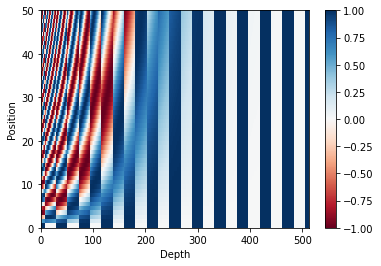

In [240]:
sample_pos_encoding = PositionalEncoding(50, 512)
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

- `어텐션 레이어`

- 단일 어텐션

In [242]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True) # 행렬내적, b전치

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32) # key 행개수
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가(특정 단어 무시)
    if mask is not None:
        logits += (mask * -1e9) # 무한한 음수값

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

- 멀티 헤드 어텐션

In [243]:
class MultiHeadAttention(tf.keras.layers.Layer):
  
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # 각 어텐션별 뎁스

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
          'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

- `마스킹`

- 패딩 마스킹(Padding Masking)

In [244]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, sequence length)

- 룩 어헤드 마스킹(Look-ahead masking)

In [245]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 2) 인코더

- `단일 인코더`

In [247]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

- `인코더 여러층 쌓기`

In [248]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 3) 디코더

- `단일 디코더`

In [262]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
    d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
    d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)	
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

- `디코더 여러층 쌓기`

In [263]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 4) 트랜스포머 함수 정의

In [265]:
def transformer(vocab_size,
              num_layers,
              units,
              d_model,
              num_heads,
              dropout,
              name="transformer"):

    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
    create_padding_mask, output_shape=(1, 1, None),
    name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
    create_look_ahead_mask,
    output_shape=(1, None, None),
    name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
    create_padding_mask, output_shape=(1, 1, None),
    name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
    vocab_size=vocab_size,
    num_layers=num_layers,
    units=units,
    d_model=d_model,
    num_heads=num_heads,
    dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
    vocab_size=vocab_size,
    num_layers=num_layers,
    units=units,
    d_model=d_model,
    num_heads=num_heads,
    dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 5) 모델 생성

- 개선 시 layer 층, D_model, DROPOUT 등을 새로이 조정할 수 있을 것이다.

In [266]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
  vocab_size=VOCAB_SIZE,
  num_layers=NUM_LAYERS,
  units=UNITS,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 6) 손실 함수 정의

In [267]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 7) 커스텀 학습 (콜백함수_LearningRateSchedule)

In [268]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 시각화용 예시(d_model=128, step=200000)

Text(0.5, 0, 'Train Step')

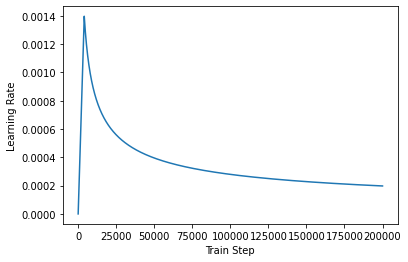

In [269]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 8) 학습 시키기

- 모델 컴파일

In [272]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

- 학습

In [273]:
EPOCHS = 25
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/25
185/185 [==============================] - 29s 55ms/step - loss: 1.4559 - accuracy: 0.0288
Epoch 2/25
185/185 [==============================] - 10s 54ms/step - loss: 1.1824 - accuracy: 0.0495
Epoch 3/25
185/185 [==============================] - 10s 54ms/step - loss: 1.0065 - accuracy: 0.0507
Epoch 4/25
185/185 [==============================] - 10s 54ms/step - loss: 0.9306 - accuracy: 0.0543
Epoch 5/25
185/185 [==============================] - 10s 55ms/step - loss: 0.8727 - accuracy: 0.0575
Epoch 6/25
185/185 [==============================] - 10s 55ms/step - loss: 0.8135 - accuracy: 0.0618
Epoch 7/25
185/185 [==============================] - 10s 55ms/step - loss: 0.7480 - accuracy: 0.0676
Epoch 8/25
185/185 [==============================] - 10s 55ms/step - loss: 0.6754 - accuracy: 0.0752
Epoch 9/25
185/185 [==============================] - 10s 54ms/step - loss: 0.5957 - accuracy: 0.0838
Epoch 10/25
185/185 [==============================] - 10s 54ms/step - loss: 0.514

- 학습이 끝났는데도 loss함수가 감소세를 보여 학습률을 차차 낮추는 커스텀 콜백 함수를 믿고 100회 정도 epochs를 추가해보았다.

In [281]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0256 - accuracy: 0.1688
Epoch 2/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0216 - accuracy: 0.1699
Epoch 3/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0204 - accuracy: 0.1703
Epoch 4/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0192 - accuracy: 0.1704
Epoch 5/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0172 - accuracy: 0.1709
Epoch 6/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0157 - accuracy: 0.1715
Epoch 7/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0143 - accuracy: 0.1717
Epoch 8/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0134 - accuracy: 0.1721
Epoch 9/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0120 - accuracy: 0.1723
Epoch 10/100
185/185 [==============================] - 10s 54ms/step - l

185/185 [==============================] - 10s 54ms/step - loss: 0.0019 - accuracy: 0.1746
Epoch 80/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0018 - accuracy: 0.1746
Epoch 81/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0019 - accuracy: 0.1746
Epoch 82/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0021 - accuracy: 0.1746
Epoch 83/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0019 - accuracy: 0.1746
Epoch 84/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0019 - accuracy: 0.1746
Epoch 85/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0018 - accuracy: 0.1746
Epoch 86/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0016 - accuracy: 0.1747
Epoch 87/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0017 - accuracy: 0.1746
Epoch 88/100
185/185 [==============================] - 10s 54ms/step - loss:

### Step 5. 모델 평가하기

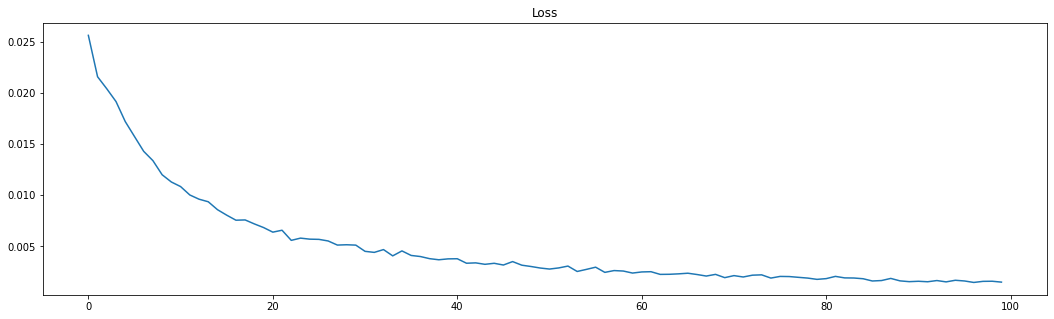

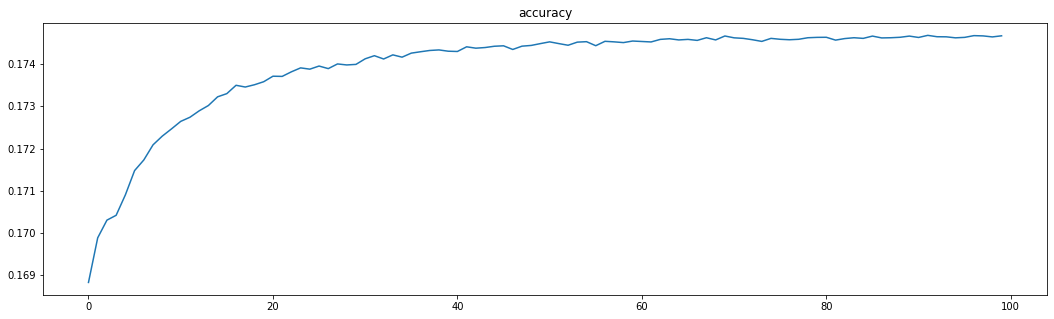

In [293]:
plt.figure(figsize=(18,5))
plt.title("Loss")
plt.plot(history.history['loss'])
plt.show()

plt.figure(figsize=(18,5))
plt.title("accuracy")
plt.plot(history.history['accuracy'])
plt.show()

- 100회 추가적으로 돌려보았더니, 40회 이후부터 accuracy든, loss든 큰 개선점을 찾지 못하는 듯하다.
- 또한 추가적으로 과적합에 대한 걱정으로 현재 데이터와 데이터 내에 없는 문구의 답변을 비교해보고자 한다.

In [276]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [277]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

- `후보군 선정`

In [307]:
ask_list = [df['Q'][17], df['Q'][7], df['Q'][11083], df['Q'][1]]
answer_list = [df['A'][17], df['A'][7], df['A'][11083], df['A'][1]]

In [308]:
ask_list

['가스불 켜고 나갔어',
 'SNS 맞팔 왜 안하지 ㅠ',
 '좋아하는 사람 생기면 어떻게든 SNS같은 거 알아내서 친신하고 그래 ?',
 '1지망 학교 떨어졌어']

In [309]:
answer_list

['빨리 집에 돌아가서 끄고 나오세요 .',
 '잘 모르고 있을 수도 있어요 .',
 '다가가는 방법 중에 하나니까요 .',
 '위로해 드립니다 .']

- 1번(일반 문장)
- 2번(한국어 초성, 중성 사용)
- 3번(영단어 포함 문장)
- 4번(숫자 사용)

In [312]:
for i in range(4) :
    sentence_generation(ask_list[i])
    print(f'실제 : {answer_list[i]}')
    print()

입력 : 가스불 켜고 나갔어
출력 : 빨리 집에 돌아가서 끄고 나오세요 .
실제 : 빨리 집에 돌아가서 끄고 나오세요 .

입력 : SNS 맞팔 왜 안하지 ㅠ
출력 : 잘 모르고 있을 수도 있어요 .
실제 : 잘 모르고 있을 수도 있어요 .

입력 : 좋아하는 사람 생기면 어떻게든 SNS같은 거 알아내서 친신하고 그래 ?
출력 : 다가가는 방법 중에 하나니까요 .
실제 : 다가가는 방법 중에 하나니까요 .

입력 : 1지망 학교 떨어졌어
출력 : 위로해 드립니다 .
실제 : 위로해 드립니다 .



- 묘하게 과한 학습이 진행되지 않았을까라는 생각이 든다.

- gpt에게 질문을 만들어 달라한 뒤, 해당 질문에 대한 대답을 해달라하여 진행시켜보겠다.

---

물론이죠! 아래는 재미있고 다양한 주제의 몇 가지 질문입니다. 😄

- 만약 오늘 하루만 반복해서 살 수 있다면, 어떤 일을 하고 싶나요?
- 가장 좋아하는 음식은 무엇이고, 그 음식을 왜 좋아하나요?
- 만약 시간을 되돌릴 수 있다면, 어떤 순간으로 돌아가고 싶나요?
- 세계 어디든 여행해 볼 수 있다면, 어느 나라로 가고 싶나요?
- 만약 한 가지 능력을 얻을 수 있다면, 어떤 능력을 가지고 싶나요?

In [316]:
sentence_generation('만약 오늘 하루만 반복해서 살 수 있다면, 어떤 일을 하고 싶나요?')

입력 : 만약 오늘 하루만 반복해서 살 수 있다면, 어떤 일을 하고 싶나요?
출력 : 잘할 수 있을 거예요 .


'잘할 수 있을 거예요 .'

- `gpt : 여러 국가를 여행하며 다양한 문화를 경험하고 싶어요.`

In [317]:
sentence_generation('가장 좋아하는 음식은 무엇이고, 그 음식을 왜 좋아하나요?')

입력 : 가장 좋아하는 음식은 무엇이고, 그 음식을 왜 좋아하나요?
출력 : 사랑은 재채기 같은 거니까요 .


'사랑은 재채기 같은 거니까요 .'

- `gpt : 라면을 정말 좋아해요! 맛도 좋지만 편리하게 끓여 먹을 수 있어서 특히 좋아합니다.`

In [318]:
sentence_generation('만약 시간을 되돌릴 수 있다면, 어떤 순간으로 돌아가고 싶나요?')

입력 : 만약 시간을 되돌릴 수 있다면, 어떤 순간으로 돌아가고 싶나요?
출력 : 저랑 한 잔 해요 .


'저랑 한 잔 해요 .'

- `gpt : 어린 시절 가족과 함께 보낸 특별한 기억이 있는 그 순간으로 돌아가고 싶어요.`

In [320]:
sentence_generation('세계 어디든 여행해 볼 수 있다면, 어느 나라로 가고 싶나요?')

입력 : 세계 어디든 여행해 볼 수 있다면, 어느 나라로 가고 싶나요?
출력 : 제 생일도 축하해 주세요 .


'제 생일도 축하해 주세요 .'

- `gpt : 이탈리아! 아름다운 풍경과 맛있는 음식을 즐기고 싶어요.`

In [321]:
sentence_generation('마법의 램프를 만났는데 세 가지 소원을 빌 수 있다면, 무엇을 빌고 싶나요?')

입력 : 마법의 램프를 만났는데 세 가지 소원을 빌 수 있다면, 무엇을 빌고 싶나요?
출력 : 조심하세요 .


'조심하세요 .'

- `gpt : 1) 모든 언어를 순간적으로 배울 수 있는 능력, 2) 세계 평화, 3) 모든 생명체에게 행복과 번영`

In [322]:
sentence_generation('만약 한 가지 능력을 얻을 수 있다면, 어떤 능력을 가지고 싶나요?')

입력 : 만약 한 가지 능력을 얻을 수 있다면, 어떤 능력을 가지고 싶나요?
출력 : 약 먹고 쉬어야 해요 .


'약 먹고 쉬어야 해요 .'

- `gpt : 모든 생명체의 감정을 이해하고 공감할 수 있는 능력`

---

- 왜 저런 답변을 내었을까? 각 answer와 비슷한 답변이 df['A']이 있는 지 확인해보겠다.

In [323]:
# 만약 오늘 하루만 반복해서 살 수 있다면, 어떤 일을 하고 싶나요?
df[df['A'] == '잘할 수 있을 거예요 .']

,Q,A,label
1190,대기업 취직 어려울까,잘할 수 있을 거예요 .,0
1191,대기업에 취직하고 싶어,잘할 수 있을 거예요 .,0
1948,발표 무사히 끝내고 싶어,잘할 수 있을 거예요 .,0
1949,발표 잘 하고 싶어,잘할 수 있을 거예요 .,0
3822,일에 적응하면 좀 더 잘 할 수 있을까,잘할 수 있을 거예요 .,0
4980,학교 잘 적을할 수 있을까 ?,잘할 수 있을 거예요 .,0
4981,학교 적을하고 잘 다닐 수 있을까 ?,잘할 수 있을 거예요 .,0
5221,회사 적응할 수 있겠지 ?,잘할 수 있을 거예요 .,0
5228,회사에 빨리 적응해야 할텐데,잘할 수 있을 거예요 .,0
5230,회사에 적응 잘 하고 싶어,잘할 수 있을 거예요 .,0


- 단순히 많아서 낸 것 같다.

In [324]:
# 가장 좋아하는 음식은 무엇이고, 그 음식을 왜 좋아하나요?
df[df['A'] == '사랑은 재채기 같은 거니까요 .']

,Q,A,label
5776,나도 모르게 니 생각을 하고 있어,사랑은 재채기 같은 거니까요 .,1


- 단어 임베딩의 위치가 비슷해서 나온건가??
    - 몇몇 단어의 번호가 생각보다 근처이다.

In [350]:
print(f'생각 : {vocab.index("생각")}')
print(f'음식 : {vocab.index("음식")}')
print(f'사랑 : {vocab.index("사랑")}')
print(f'가장 : {vocab.index("가장")}')

생각 : 355
음식 : 4066
사랑 : 212
가장 : 398


In [351]:
print(f'재채기 : {vocab.index("재채기")}')

ValueError: '재채기' is not in list

In [325]:
# 만약 시간을 되돌릴 수 있다면, 어떤 순간으로 돌아가고 싶나요?
df[df['A'] == '저랑 한 잔 해요 .']

,Q,A,label
1574,맥주 한 잔 어때 ?,저랑 한 잔 해요 .,0
1575,맥주 한 잔 할래 ?,저랑 한 잔 해요 .,0
2616,술 마시고 싶다,저랑 한 잔 해요 .,0
5008,한 잔 하고 싶다,저랑 한 잔 해요 .,0


In [327]:
# 세계 어디든 여행해 볼 수 있다면, 어느 나라로 가고 싶나요?
df[df['A'] == '제 생일도 축하해 주세요 .']

,Q,A,label
6679,생일축하했다 바보야,제 생일도 축하해 주세요 .,1


In [352]:
# 마법의 램프를 만났는데 세 가지 소원을 빌 수 있다면, 무엇을 빌고 싶나요?
df[df['A'] == '조심하세요 .']

,Q,A,label
409,길이 미끄러워서 미끄러질뻔했어,조심하세요 .,0
411,길이 얼어서 미끄러질뻔했어,조심하세요 .,0
989,넘어질뻔했어,조심하세요 .,0
1699,모기가 너무 많아 .,조심하세요 .,0
1700,모기가 웽웽거려 .,조심하세요 .,0
1761,무서워서 달려왔어,조심하세요 .,0
1762,무서워서 뛰어 왔어,조심하세요 .,0
2171,불 날 뻔,조심하세요 .,0
2172,불 날 뻔했어,조심하세요 .,0
2243,빨리 걷다가 넘어질뻔,조심하세요 .,0


In [339]:
# 만약 한 가지 능력을 얻을 수 있다면, 어떤 능력을 가지고 싶나요?
df[df['A'] == '약 먹고 쉬어야 해요 .']

,Q,A,label
3007,약 기운에 졸음이 몰려왔어,약 먹고 쉬어야 해요 .,0
3009,약 먹었더니 졸려,약 먹고 쉬어야 해요 .,0


---

- 취약점을 찾고자 generate와 실제 데이터를 비교해보고자 한다.

In [362]:
def sentence_generation2(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    return predicted_sentence

- 실행 중~~

In [ ]:
gen_data = df.copy()
gen_data["G"] = gen_data['Q'].apply(lambda x:sentence_generation2(x))
differ = gen_data[gen_data['A'] != gen_data['G']]

### 회고
#### Keep
- 이것저것 가능한한 과정을 이해해보려 노력해본 것 같다. 더불어 다양한 시도를 하며 모든 결정을 근거있게 해보려 노력하였다.

#### Problem
- 문제는 단순히 에폭을 늘리는 것만으로 모델의 성능이 오르는 것 같지 않다. 데이터 불균형의 문제점을 파악하고도 따로 데이터 증강을 시도하지 않았다.

#### Try
- gpt, 실제 정답 데이터와 예측 데이터를 직접 눈으로 비교해보려 노력하였다.